<a href="https://colab.research.google.com/github/sharadv99/capstone-OpioidAddictionRisk/blob/master/Past_Work_Variable_Breakdown_Sharad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
with zipfile.ZipFile("data.pickle.zip") as z:
    data = pd.read_pickle(z.open("data.pickle"))

In [14]:
data.shape

(53358, 2631)

**Add misuse data**

In [55]:
misuseCodes = [1, 2, 8]
data['MISUSE'] = data.apply(lambda row: 1 if row.PNRNMREC in misuseCodes else 0,
                                              axis=1)

**Survey Questions sentiment - TEAM : should we use them? how?**

Caveats of using survey data

In [15]:
# RESP SAID INTERVIEW WAS TOO LONG
data.TOOLONG.value_counts()

2     49088
1      4105
98      165
Name: TOOLONG, dtype: int64

In [16]:
# DID RESP HAVE TROUBLE UNDERSTANDING INTERVIEW
data.TROUBUND.value_counts()

2     50708
1      2485
98      165
Name: TROUBUND, dtype: int64

# ALCOHOL

Variables of Interest :

ALCEVER - EVER HAD DRINK OF ALCOHOLIC BEVERAGE -- boolean  
ALCTRY - AGE WHEN FIRST DRANK ALCOHOLIC BEVERAGE - continuous but requires some bucketing  
**ALCYFU - YEAR OF FIRST ALCOHOL USE - 64% SKIPPED -- IGNORE VARIABLE FOR FURTHER ANALYSIS**  
**ALCMFU - MONTH OF FIRST ALCOHOL USE - 64% SKIPPED -- IGNORE VARIABLE FOR FURTHER ANALYSIS**  
ALCREC - TIME SINCE LAST DRANK ALCOHOLIC BEVERAGE -- requires bucketing/binarizing   
ALCYRTOT - TOTAL # OF DAYS USED ALCOHOL IN PAST 12 MOS -- continuous requires bucketing/binarizing  
ALBSTWAY - EASIEST WAY TO TELL US # DAYS DRANK ALCOHOL -- requires bucketing/binarizing   
ALDAYPYR - NUMBER DAYS DRANK ALCOHOL IN PAST 12 MOS -- continuous but requires bucketing  
ALDAYPMO - # DAYS PER MONTH DRANK ALCOHOL IN PAST 12 MOS -- continuous but requires bucketing  
ALDAYPWK - # DAYS PER WEEK DRANK ALCOHOL IN PAST 12 MOS -- continuous but requires bucketing  
ALCDAYS - # DAYS HAD ONE OR MORE DRINKS PAST 30 DAYS -- continuous but requires bucketing  
AL30EST - BEST ESTIMATE # DAYS HAD ONE OR MORE DRINKS -- continuous but requires bucketing  
ALCUS30D - USUAL # OF DRINKS PER DAY PAST 30 DAYS -- continuous but requires bucketing  
ALCBNG30D - # DAYS HAD FOUR/FIVE OR MORE DRINKS PAST 30 DYS -- continuous but requires bucketing 

### ALCEVR

In [12]:
data.ALCEVER.value_counts()

1    45147
0     8211
Name: ALCEVER, dtype: int64

In [11]:
data["ALCEVER"] = data["ALCEVER"].apply(lambda row: 0 if row in [2, 85,94, 97] else row) #Never used smokeless tobacco

### ALCTRY

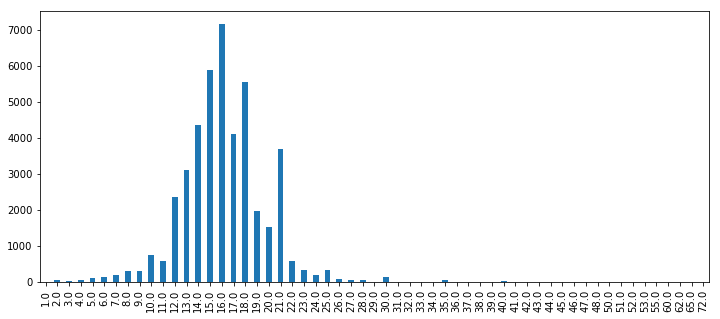

In [10]:
data["ALCTRY"] = data["ALCTRY"].apply(lambda row: np.nan if row in [985,991,994,997, 998, 999] else row) #nulls for non smokers
plt.figure(figsize=(12,5))
data.ALCTRY.value_counts().sort_index().plot(kind = "bar")

### ALCREC, ALCYRTOT, ALBSTWAY, ALDAYPYR, ALDAYPMO, ALDAYPWK
ALCREC - TIME SINCE LAST DRANK ALCOHOLIC BEVERAGE -- requires bucketing/binarizing   
ALCYRTOT - TOTAL # OF DAYS USED ALCOHOL IN PAST 12 MOS -- continuous requires bucketing/binarizing  
ALBSTWAY - EASIEST WAY TO TELL US # DAYS DRANK ALCOHOL -- requires bucketing/binarizing   
ALDAYPYR - NUMBER DAYS DRANK ALCOHOL IN PAST 12 MOS -- continuous but requires bucketing  
ALDAYPMO - # DAYS PER MONTH DRANK ALCOHOL IN PAST 12 MOS -- continuous but requires bucketing  
ALDAYPWK - # DAYS PER WEEK DRANK ALCOHOL IN PAST 12 MOS -- continuous but requires bucketing  

#### ALREC: Time since last drank alcohol

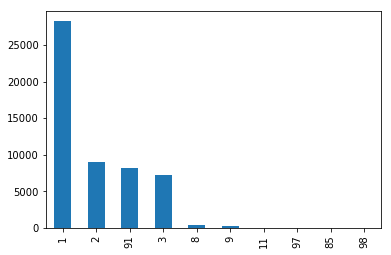

In [17]:
data["ALCREC"].value_counts().plot(kind = "bar")

#### ALCYRTOT: Total # of days used alcohol in past 12 days

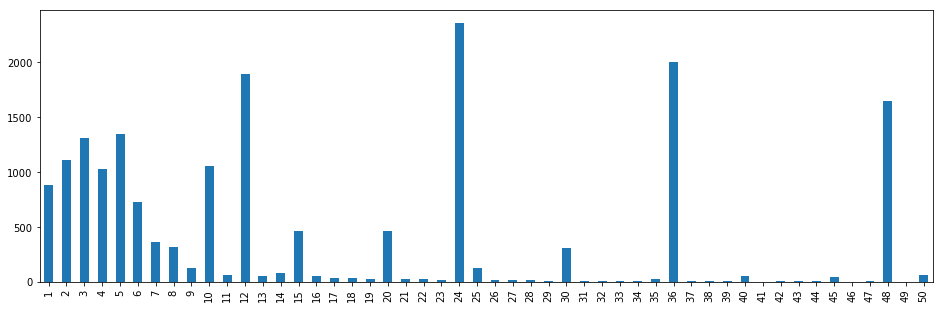

In [24]:
plt.figure(figsize=(16,5))
data["ALCYRTOT"].value_counts().sort_index()[:50].plot(kind = "bar")

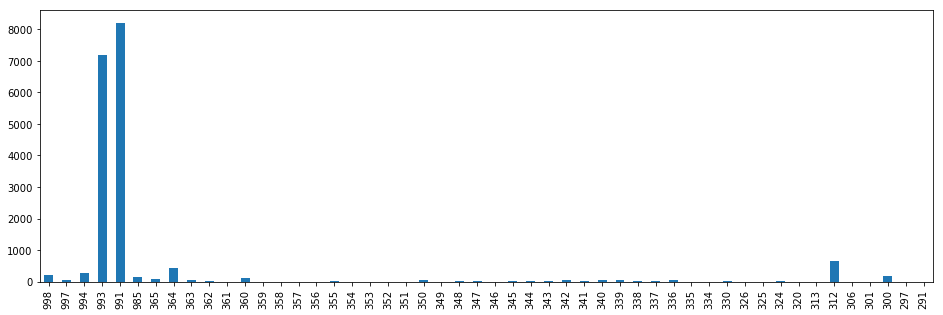

In [26]:
plt.figure(figsize=(16,5))
data["ALCYRTOT"].value_counts().sort_index(ascending=False)[:50].plot(kind = "bar")

### Alcohol Days

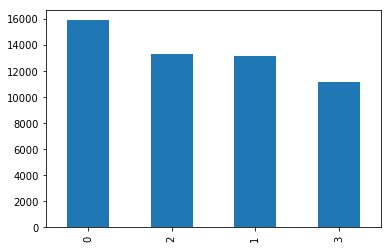

In [36]:
data["ALBSTWAY"] = data["ALBSTWAY"].apply(lambda row: 1 if row in [1,11] else row).apply(lambda row: 3 if row in [3,13] else row).apply(lambda row: 2 if row in [2,12] else row).apply(lambda row: 0 if row in [85, 91,93, 94, 97, 98] else row)
data["ALBSTWAY"].value_counts().plot(kind = "bar")

In [50]:
def get_day_12mo (row):
    if row['ALBSTWAY'] == 0 :
        return 0
    if row['ALBSTWAY'] == 1:
        return  row['ALDAYPWK'] * 52 if (row['ALDAYPWK'] < 90) else 0
    if row['ALBSTWAY'] == 2:
        return row['ALDAYPMO'] * 12 if row['ALDAYPMO'] < 90 else 0
    if row['ALBSTWAY'] == 3:
        return row['ALDAYPYR'] if row['ALDAYPYR'] < 90 else 0
    return None

In [51]:
data[["ALBSTWAY", "ALDAYPYR", "ALDAYPMO", "ALDAYPWK"]].head()

,ALBSTWAY,ALDAYPYR,ALDAYPMO,ALDAYPWK
19,0,991,91,91
20,2,999,5,99
21,3,20,99,99
23,0,993,93,93
33,2,999,16,99


In [52]:
data["ALCDAYS"] = data[["ALBSTWAY", "ALDAYPYR", "ALDAYPMO", "ALDAYPWK"]].apply(lambda row: get_day_12mo(row), axis=1)

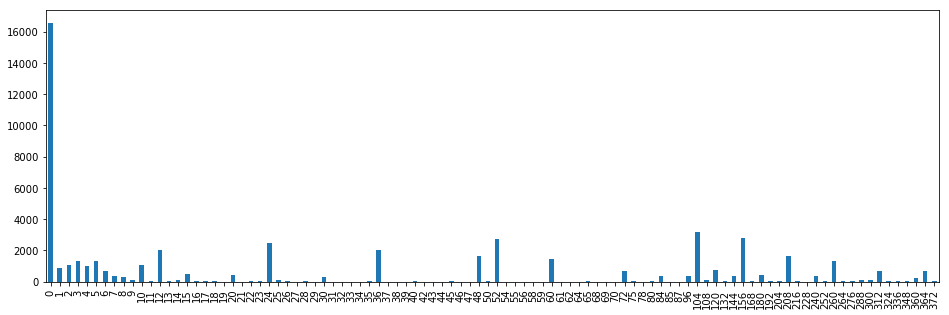

In [54]:
plt.figure(figsize=(16,5))
data["ALCDAYS"].value_counts().sort_index().plot(kind = "bar")

# TOOLONG AND TROUBUND - Correlation check 

In [63]:
continuous_vars = ["CIGTRY", "CIG30USE", "CIG30AV", "CIGAGE", "SMKLSSTRY", "SMKLSS30N", "CIGARTRY", "CGR30USE"]
for i in continuous_vars:
    print("TOOLONG and {} have a correlation of: {:0.4f}".format(i, data[['TOOLONG', i]].corr().iloc[0,1]))
    
print("\n")
for i in continuous_vars:
    print("Troubund and {} have a correlation of: {:0.4f}".format(i, data[['TROUBUND', i]].corr().iloc[0,1]))
    


TOOLONG and CIGTRY have a correlation of: -0.0046
TOOLONG and CIG30USE have a correlation of: -0.0037
TOOLONG and CIG30AV have a correlation of: -0.0040
TOOLONG and CIGAGE have a correlation of: -0.0050
TOOLONG and SMKLSSTRY have a correlation of: -0.0004
TOOLONG and SMKLSS30N have a correlation of: 0.0019
TOOLONG and CIGARTRY have a correlation of: 0.0037
TOOLONG and CGR30USE have a correlation of: 0.0080


Troubund and CIGTRY have a correlation of: -0.0077
Troubund and CIG30USE have a correlation of: -0.0068
Troubund and CIG30AV have a correlation of: -0.0072
Troubund and CIGAGE have a correlation of: -0.0081
Troubund and SMKLSSTRY have a correlation of: -0.0020
Troubund and SMKLSS30N have a correlation of: 0.0013
Troubund and CIGARTRY have a correlation of: 0.0023
Troubund and CGR30USE have a correlation of: 0.0070


# MENTAL HEALTH UTILIZATION VARIABLES

### AUINPYR1 Len : 2 STAY OVNT IN HOSP FOR MH TRMT PST 12 MOS

### AUOPTYR1 Len : 2 RCVD OUTPATIENT MH TRMT PST 12 MOS

### AURXYR1 Len : 2 TOOK ANY PRESCRIP MED FOR MH COND PAST 12 MOS

### AUUNMTYR1 Len : 2 NEEDED MH TRMT BUT DIDN'T GET IT PAST 12 MOS

### AUALTYR1 Len : 2 RCVD ALTERNATIVE MENT HLTH TRMT PAST 12 MOS

# MENTAL HEALTH RECODED VARIABLES

### DSTNRV301 Len : 2 HOW OFTEN FELT NERVOUS PAST 30 DAYS

### DSTHOP301 Len : 2 HOW OFTEN FELT HOPELESS PAST 30 DAYS

### DSTRST301 Len : 2 HOW OFTEN FELT RESTLESS/FIDGETY PST 30 DYS

### DSTCHR301 Len : 2 HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP

### DSTEFF301 Len : 2 HOW OFT FELT EVERYTHING EFFORT PST 30 DYS

### DSTNGD301 Len : 2 HOW OFT FELT DOWN/WTHLSS/NO GOOD PST 30 DYS

### DSTWORST1 Len : 2 MON IN PST 12 MOS FELT WORSE THAN PST 30 DYS

### IMPREMEM1 Len : 2 DIFFICULTY REMEMBERING ONE MO IN PST 12 MOS

### IMPCONCN1 Len : 2 DIFFICULTY CONCENTRATING ONE MO IN PST 12 MOS

### IMPGOUT1 Len : 2 DIFFICULTY GOING OUT ONE MO IN PST 12 MO

### IMPPEOP1 Len : 2 DIFFICULTY DEALING W STRANGERS ONE MO IN PST 12 M

### IMPSOC1 Len : 2 DIFFICULTY PARTICIPATE IN SOCIAL ACT 1 MO /12 MO

### IMPHHLD1 Len : 2 DIFFICULTY HOUSE RESPONS ONE MO IN PST 12 MO

### IMPWEEKS1 Len : 2 NUM WEEKS HAVE DIFFICULTIES BECAUSE OF MENTL HLTH

### IMPDYFRQ1 Len : 2 HOW MANY DAYS IN WEEK DID YOU HAVE DIFFICULTIES

### IMPYDAYS1 Len : 3 HOW MANY DAY IN PAST YR YOU WERE UNABLE TO WORK

### SUICTHNK1 Len : 2 SERIOUSLY THINK ABOUT KILLING SELF PST 12 MOS